### OVS-SGX

This notebook will be used to display the results of my optimized version of ovs-sgx.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  
plt.rcParams['figure.figsize'] = (12.0, 6.0)
sns.set()

In [2]:
DATA_PATH = './data/permanent'

## Table of content:
* [Flow table](#1)
    * [Add flow](#1.1)
        * [Simple flow](#1.1.1)
    * [Delete flow](#1.2)
        * [Strict](#1.2.1)
        * [Loose](#1.2.2)
    * [Modify flow](#1.3)
        * [Strict](#1.3.1)
        * [Loose](#1.3.2)
    * [Flow eviction](#1.4)
        * [Batch](#1.4.1)
        * [Single](#1.4.2)
* [Stats Request](#2)
    * [Dump flows](#2.1)
* [Upcall (WORK IN PROGRESS)](#3) 
    * [Flow miss](#3.1)
        * [With SDN controller intervention](#3.1.1)
        * [Without SDN controller intervention](#3.1.2)

# 1. Flow table <a class="anchor" id="1"></a>

## 1.1 Add flows <a class="anchor" id="1.1"></a>

#### 1.1.1 Simple flow <a class="anchor" id="1.1.1"></a>
This benchmark consisted of adding a simple (only a single table flow table had to be consulted) flow to the flow tables.

In [69]:
add_flow_df = pd.read_csv(DATA_PATH + "/add_flow.csv");

In [70]:
add_flow_df.describe()

,BASELINE,SGX,OPTIMIZED,HOTCALL,HOTCALL+OPTIMIZED
count,2.000400e+04,2.000400e+04,2.000400e+04,2.000400e+04,20004.000000
mean,9.221528e+14,2.766458e+15,9.221528e+14,1.778981e+04,11129.986103
std,1.304251e+17,2.258917e+17,1.304251e+17,1.136045e+05,7290.864330
min,1.919000e+03,7.448000e+04,4.160800e+04,6.669000e+03,4257.000000
25%,4.651000e+03,1.008070e+05,5.467000e+04,1.153600e+04,8783.000000
50%,5.078500e+03,1.043050e+05,5.790700e+04,1.439700e+04,9920.000000
75%,6.118000e+03,1.116472e+05,6.422675e+04,1.778050e+04,11807.000000
max,1.844674e+19,1.844674e+19,1.844674e+19,1.326423e+07,418939.000000


The above table tells us that there is some very large outliers in the BASELINE and SGX classes. In order for these outliers to not mess up the plots, we will remove them.

In [71]:
add_flow_df = add_flow_df\
    .mask(add_flow_df > add_flow_df.quantile(0.95), axis=0)

In [72]:
add_flow_df.count()

BASELINE             19003
SGX                  19003
OPTIMIZED            19003
HOTCALL              19003
HOTCALL+OPTIMIZED    19003
dtype: int64

Median execution time for add-flow operaration:

In [73]:
add_flow_df.median()

BASELINE               5022.0
SGX                  103916.0
OPTIMIZED             57446.0
HOTCALL               13978.0
HOTCALL+OPTIMIZED      9793.0
dtype: float64

Text(0, 0.5, 'Time')

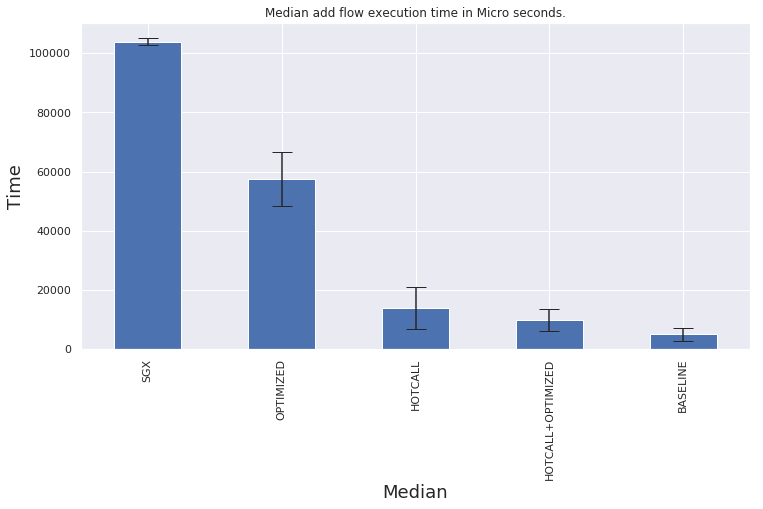

In [127]:
ax = add_flow_df \
    .median() \
    .sort_values(ascending=False) \
    .plot(kind='bar', 
          title="Median add flow execution time in Micro seconds.", 
          capsize=10, yerr=add_flow_df.std().tolist())
ax.set_xlabel('Median', fontsize=18)
ax.set_ylabel('Time', fontsize=18)

Text(0, 0.5, 'Time')

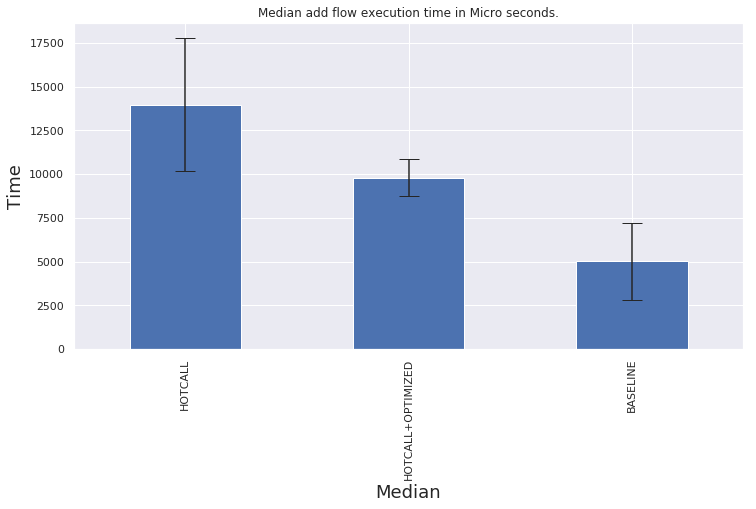

In [128]:
cols = ['HOTCALL', 'BASELINE', 'HOTCALL+OPTIMIZED']
ax = add_flow_df[cols] \
    .median() \
    .sort_values(ascending=False) \
    .plot(kind='bar', 
          title="Median add flow execution time in Micro seconds.", 
          capsize=10, yerr=add_flow_df[cols].std().tolist())
ax.set_xlabel('Median', fontsize=18)
ax.set_ylabel('Time', fontsize=18)

We can observe in the above boxplot that there are only outliers in the positive direction. 

## 1.2 Delete flows <a class="anchor" id="1.2"></a>

### 1.2.1 strict <a class="anchor" id="1.2.1"></a>

In [129]:
del_flow_strict_df = pd.read_csv(DATA_PATH + "/del_flow_strict.csv");

In [130]:
del_flow_strict_df.describe()

,BASELINE,SGX,OPTIMIZED,HOTCALL,HOTCALL+OPTIMIZED
count,20001.000000,20001.000000,20001.000000,2.000100e+04,2.000100e+04
mean,39880.136593,34622.453527,36015.799960,1.686245e+04,9.222911e+14
std,11298.813543,10733.491988,12235.200126,2.981830e+04,1.304349e+17
min,33057.000000,21955.000000,21450.000000,1.138300e+04,1.104000e+04
25%,34906.000000,28682.000000,30202.000000,1.405700e+04,1.386100e+04
50%,36372.000000,32312.000000,32927.000000,1.495500e+04,1.468700e+04
75%,42052.000000,36897.000000,38414.000000,1.695700e+04,1.641400e+04
max,265217.000000,265537.000000,401333.000000,3.017522e+06,1.844674e+19


In [131]:
del_flow_strict_df = del_flow_strict_df\
    .mask(del_flow_strict_df > del_flow_strict_df.quantile(0.95), axis=0)

Median execution time:

In [132]:
del_flow_strict_df.describe()

,BASELINE,SGX,OPTIMIZED,HOTCALL,HOTCALL+OPTIMIZED
count,19001.000000,19001.000000,19001.000000,19001.000000,19001.000000
mean,38118.553129,32753.670754,33915.454081,15523.348455,15184.615810
std,4283.985360,5198.742131,5144.540323,2238.003974,2088.886141
min,33057.000000,21955.000000,21450.000000,11383.000000,11040.000000
25%,34836.000000,28524.000000,30044.000000,14009.000000,13817.000000
50%,36165.000000,31987.000000,32673.000000,14849.000000,14597.000000
75%,40736.000000,35824.000000,37438.000000,16405.000000,15909.000000
max,50912.000000,49906.000000,51681.000000,23467.000000,22773.000000


Text(0, 0.5, 'Time')

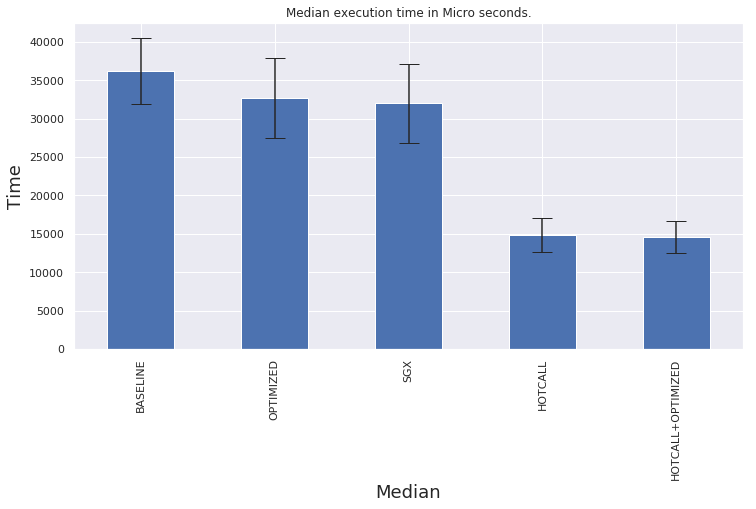

In [134]:
ax = del_flow_strict_df \
    .median() \
    .sort_values(ascending=False) \
    .plot(kind='bar', 
          title="Median execution time in Micro seconds.", 
          capsize=10, yerr=del_flow_strict_df.std().tolist())
ax.set_xlabel('Median', fontsize=18)
ax.set_ylabel('Time', fontsize=18)

### 1.2.2 loose <a class="anchor" id="1.2.2"></a>

In [135]:
del_flow_loose_df = pd.read_csv(DATA_PATH + "/del_flow_loose.csv");

In [136]:
del_flow_loose_df.describe()

,BASELINE,SGX,OPTIMIZED,HOTCALL,HOTCALL+OPTIMIZED
count,20001.000000,2.000100e+04,20001.000000,2.000100e+04,20001.000000
mean,19547.822009,9.222911e+14,97113.904205,9.222911e+14,21459.793710
std,6996.363775,1.304349e+17,23436.476721,1.304349e+17,7914.592582
min,13863.000000,9.595700e+04,77407.000000,1.859500e+04,14445.000000
25%,16054.000000,1.065170e+05,86212.000000,2.388700e+04,18214.000000
50%,17457.000000,1.128790e+05,90390.000000,2.520600e+04,19470.000000
75%,20713.000000,1.249260e+05,98701.000000,2.799100e+04,22333.000000
max,136965.000000,1.844674e+19,486875.000000,1.844674e+19,209060.000000


In [137]:
del_flow_loose_df = del_flow_loose_df\
    .mask(del_flow_loose_df > del_flow_loose_df.quantile(0.99), axis=0)

Text(0, 0.5, 'Time')

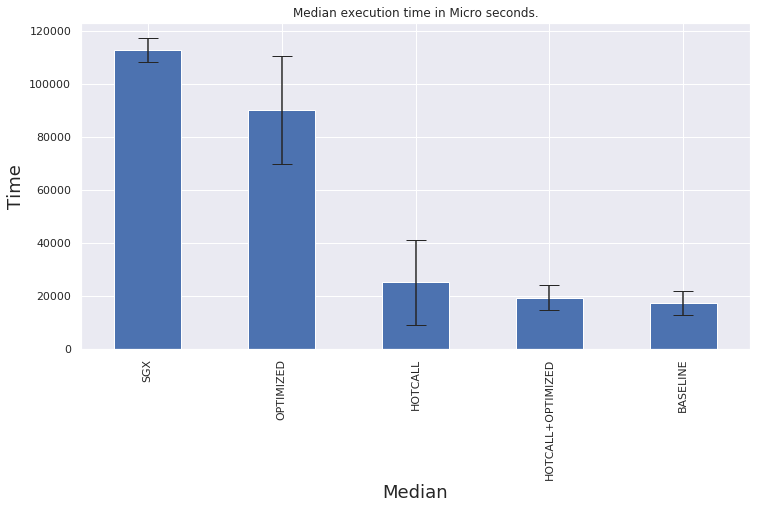

In [138]:
ax = del_flow_loose_df \
    .median() \
    .sort_values(ascending=False) \
    .plot(kind='bar', 
          title="Median execution time in Micro seconds.", 
          capsize=10, yerr=del_flow_loose_df.std().tolist())
ax.set_xlabel('Median', fontsize=18)
ax.set_ylabel('Time', fontsize=18)

Text(0, 0.5, 'Time')

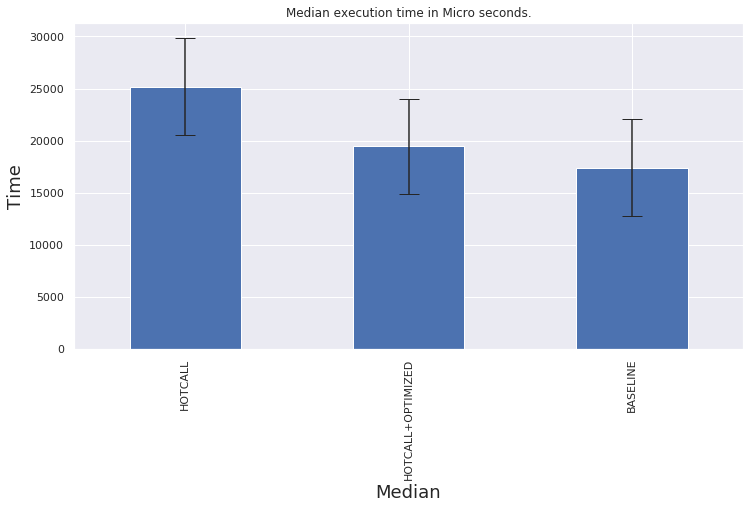

In [139]:
cols = ['HOTCALL', 'BASELINE', 'HOTCALL+OPTIMIZED']
ax = del_flow_loose_df[cols] \
    .median() \
    .sort_values(ascending=False) \
    .plot(kind='bar', 
          title="Median execution time in Micro seconds.", 
          capsize=10, yerr=del_flow_loose_df[cols].std().tolist())
ax.set_xlabel('Median', fontsize=18)
ax.set_ylabel('Time', fontsize=18)

## 1.3 Modify flows <a class="anchor" id="1.3"></a>

### 1.3.1 strict <a class="anchor" id="1.3.1"></a>

Modifies at most a single flow in each flow table which has to match exactly with the properties specified in the mod flow command.

In [86]:
mod_flow_srict_df = pd.read_csv(DATA_PATH + "/mod_flow_strict.csv");

In [87]:
mod_flow_srict_df.describe()

,BASELINE,SGX,OPTIMIZED,HOTCALL,HOTCALL+OPTIMIZED
count,5001.000000,5001.000000,5.001000e+03,5.001000e+03,5001.000000
mean,7477.075785,76731.282543,7.377222e+15,3.688611e+15,11359.709258
std,3928.873369,15325.254794,3.688611e+17,2.608503e+17,8538.137094
min,4019.000000,57923.000000,4.272600e+04,7.070000e+03,5672.000000
25%,6075.000000,68744.000000,5.203800e+04,1.013400e+04,9097.000000
50%,6841.000000,73302.000000,5.564500e+04,1.152600e+04,10520.000000
75%,8158.000000,82001.000000,6.229200e+04,1.264300e+04,11557.000000
max,190184.000000,430334.000000,1.844674e+19,1.844674e+19,423194.000000


In [88]:
mod_flow_srict_df.median()

BASELINE              6841.0
SGX                  73302.0
OPTIMIZED            55645.0
HOTCALL              11526.0
HOTCALL+OPTIMIZED    10520.0
dtype: float64

In [89]:
mod_flow_srict_df = mod_flow_srict_df\
    .mask(mod_flow_srict_df > mod_flow_srict_df.quantile(0.95), axis=0)

Text(0, 0.5, 'Time')

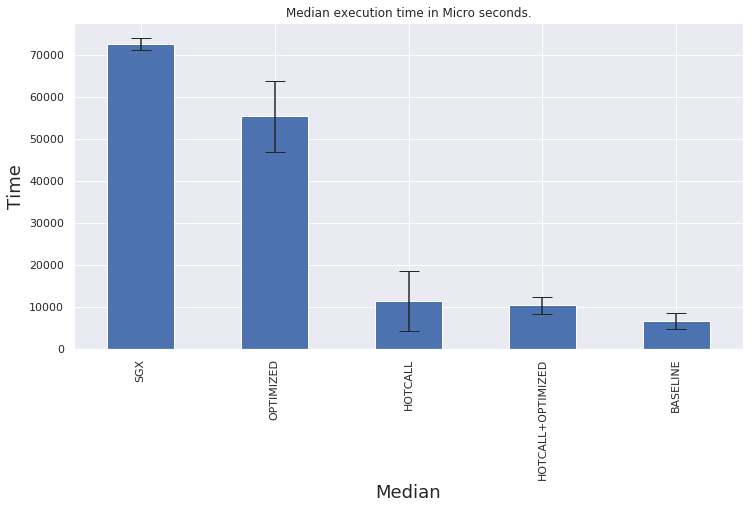

In [141]:
ax = mod_flow_srict_df \
    .median() \
    .sort_values(ascending=False) \
    .plot(kind='bar', 
          title="Median execution time in Micro seconds.",
          capsize=10, yerr=mod_flow_srict_df.std().tolist())
ax.set_xlabel('Median', fontsize=18)
ax.set_ylabel('Time', fontsize=18)

Text(0, 0.5, 'Time')

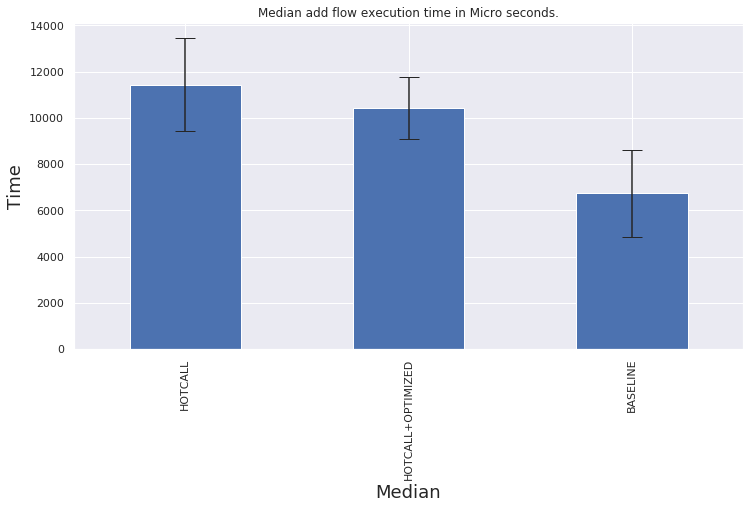

In [142]:
cols = ['HOTCALL', 'BASELINE', 'HOTCALL+OPTIMIZED']
ax = mod_flow_srict_df[cols] \
    .median() \
    .sort_values(ascending=False) \
    .plot(kind='bar', 
          title="Median add flow execution time in Micro seconds.", 
          capsize=10, yerr=mod_flow_srict_df[cols].std().tolist())
ax.set_xlabel('Median', fontsize=18)
ax.set_ylabel('Time', fontsize=18)

### 1.3.2 loose <a class="anchor" id="1.3.2"></a>

Modifies flows which matches the properties specified in the mod flow command but also supports wild card matching on the properties not specified in the command. 

In [92]:
mod_flow_loose_df = pd.read_csv(DATA_PATH + "/mod_flow_loose.csv");

In [93]:
mod_flow_loose_df.describe()

,BASELINE,SGX,OPTIMIZED,HOTCALL,HOTCALL+OPTIMIZED
count,20001.000000,2.000100e+04,2.000100e+04,2.000100e+04,2.000100e+04
mean,17435.293635,2.766873e+15,9.222911e+14,1.844582e+15,1.793267e+04
std,4634.230043,2.259086e+17,1.304349e+17,1.844582e+17,1.557761e+04
min,12968.000000,6.517300e+04,4.703600e+04,1.714200e+04,1.157800e+04
25%,15229.000000,7.355900e+04,5.591700e+04,2.021000e+04,1.430400e+04
50%,15917.000000,7.631900e+04,5.845300e+04,2.176000e+04,1.598300e+04
75%,18691.000000,8.207100e+04,6.342400e+04,2.398900e+04,1.842800e+04
max,114085.000000,1.844674e+19,1.844674e+19,1.844674e+19,1.641541e+06


In [94]:
mod_flow_loose_df = mod_flow_loose_df\
    .mask(mod_flow_loose_df > mod_flow_loose_df.quantile(0.95), axis=0)

In [95]:
mod_flow_loose_df.median()

BASELINE             15837.0
SGX                  75995.0
OPTIMIZED            58116.0
HOTCALL              21625.0
HOTCALL+OPTIMIZED    15860.0
dtype: float64

Text(0, 0.5, 'Time')

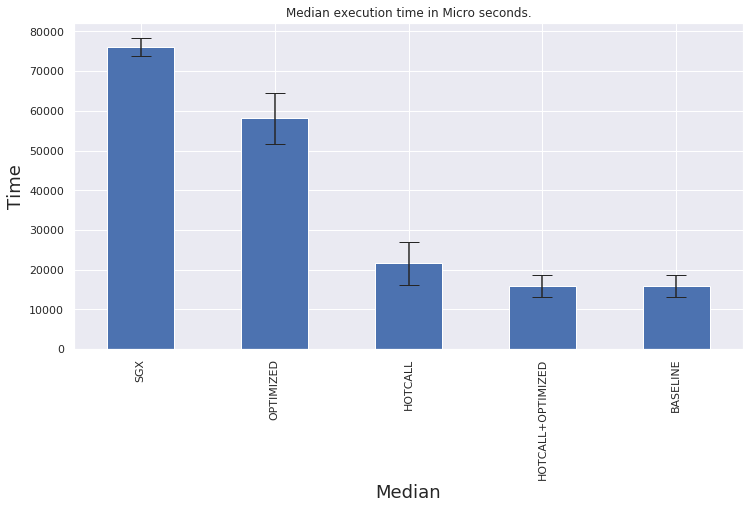

In [143]:
ax = mod_flow_loose_df \
    .median() \
    .sort_values(ascending=False) \
    .plot(kind='bar', 
          title="Median execution time in Micro seconds.", 
          capsize=10, yerr=mod_flow_loose_df.std().tolist())
ax.set_xlabel('Median', fontsize=18)
ax.set_ylabel('Time', fontsize=18)

Text(0, 0.5, 'Time')

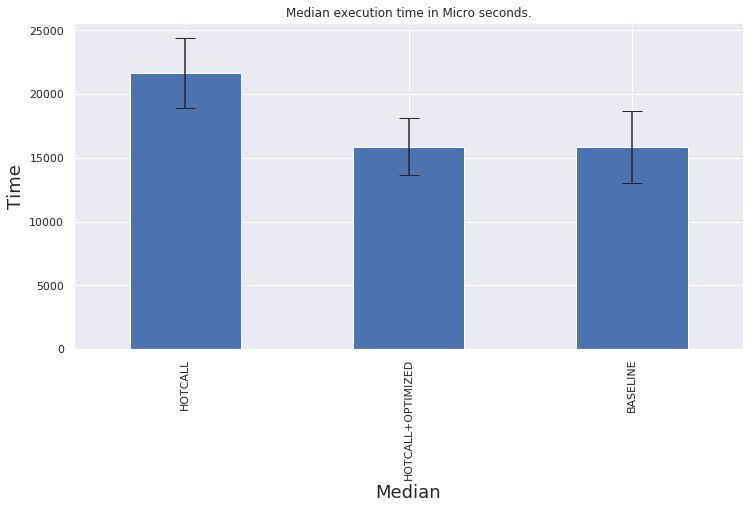

In [144]:
cols = ['HOTCALL', 'BASELINE', 'HOTCALL+OPTIMIZED']
ax = mod_flow_loose_df[cols] \
    .median() \
    .sort_values(ascending=False) \
    .plot(kind='bar', 
          title="Median execution time in Micro seconds.", 
          capsize=10, yerr=mod_flow_loose_df[cols].std().tolist())
ax.set_xlabel('Median', fontsize=18)
ax.set_ylabel('Time', fontsize=18)

## 1.4 Flow eviction <a class="anchor" id="1.4"></a>

## 1.4.1 Batch eviction <a class="anchor" id="1.4.1"></a>
Results from changing the max flow property of a flow table. Meassures the time to evict 10 rules in a batch.

In [147]:
evict_rule_batch_df = pd.read_csv(DATA_PATH + "/evict_rule_batch.csv");

In [148]:
evict_rule_batch_df = evict_rule_batch_df\
    .mask(evict_rule_batch_df > evict_rule_batch_df.quantile(0.95), axis=0)

In [149]:
evict_rule_batch_df.describe()

,BASELINE,SGX,OPTIMIZED,HOTCALL,HOTCALL+OPTIMIZED
count,4751.000000,4.751000e+03,4751.000000,4751.000000,4751.000000
mean,16948.297201,4.376510e+06,116673.913913,186197.365397,33920.508314
std,2288.238536,4.124133e+05,10351.566981,33460.894296,2699.874053
min,13879.000000,3.569341e+06,101561.000000,124454.000000,22447.000000
25%,15203.000000,4.065476e+06,108125.000000,141847.500000,31976.500000
50%,15818.000000,4.259156e+06,111989.000000,201120.000000,33598.000000
75%,19283.000000,4.595836e+06,125572.500000,207011.500000,35586.000000
max,22175.000000,5.618968e+06,145149.000000,251489.000000,42143.000000


In [150]:
evict_rule_batch_df.median()

BASELINE               15818.0
SGX                  4259156.0
OPTIMIZED             111989.0
HOTCALL               201120.0
HOTCALL+OPTIMIZED      33598.0
dtype: float64

Text(0, 0.5, 'Time')

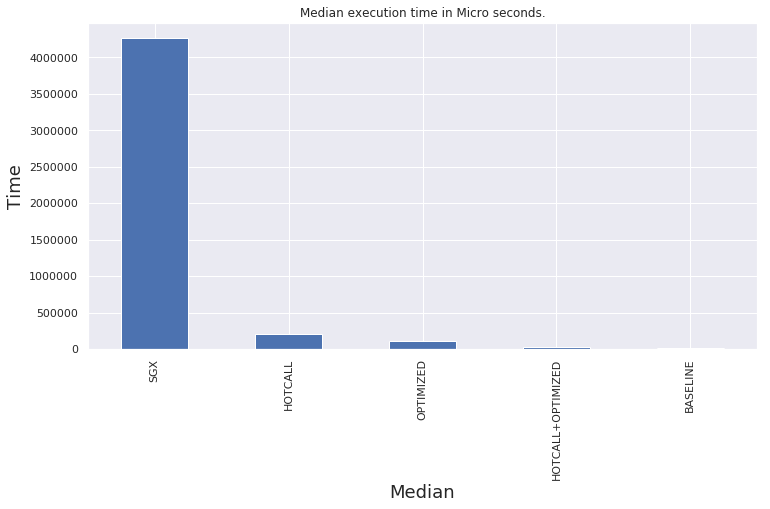

In [153]:
ax = evict_rule_batch_df \
    .median() \
    .sort_values(ascending=False) \
    .plot(kind='bar', 
          title="Median execution time in Micro seconds.")
ax.set_xlabel('Median', fontsize=18)
ax.set_ylabel('Time', fontsize=18)

Text(0, 0.5, 'Time')

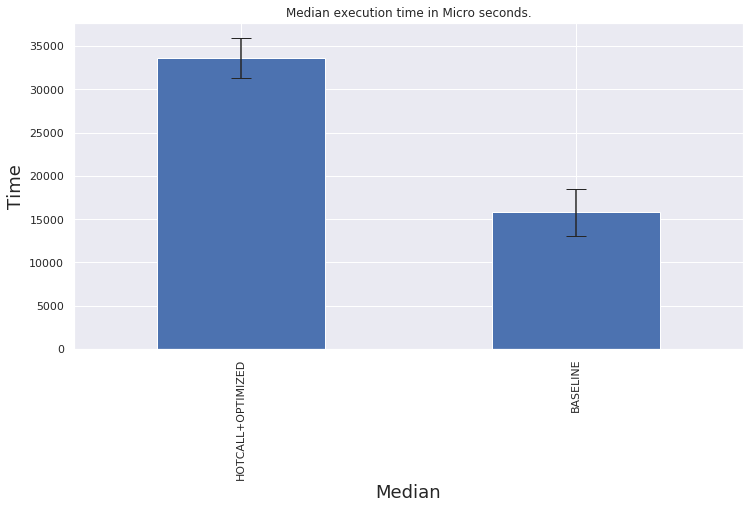

In [154]:
cols = ['BASELINE', 'HOTCALL+OPTIMIZED']
ax = evict_rule_batch_df[cols] \
    .median() \
    .sort_values(ascending=False) \
    .plot(kind='bar', 
          title="Median execution time in Micro seconds.", 
          capsize=10, yerr=evict_rule_batch_df[cols].std().tolist())
ax.set_xlabel('Median', fontsize=18)
ax.set_ylabel('Time', fontsize=18)

## 1.4.2 Single eviction <a class="anchor" id="1.4.2"></a>
Occurs when trying to add a rule to a flow table which already has the maximum amount of rules.
This benchmark meassures the time of adding a rule to a full flow table (i.e. it meassures the time for a flow addition + a flow eviction).

In [155]:
evict_rule_single_df = pd.read_csv(DATA_PATH + "/evict_rule_single.csv");

In [156]:
evict_rule_single_df = evict_rule_single_df\
    .mask(evict_rule_single_df > evict_rule_single_df.quantile(0.95), axis=0)

In [157]:
evict_rule_single_df.describe()

,BASELINE,SGX,OPTIMIZED,HOTCALL,HOTCALL+OPTIMIZED
count,4759.000000,4759.000000,4759.000000,4759.000000,4759.000000
mean,9313.023324,151239.476571,81859.769069,18697.822232,15622.574070
std,1947.155790,10887.970901,7576.952211,3769.870103,3127.411599
min,1912.000000,79000.000000,41756.000000,7880.000000,4548.000000
25%,7745.000000,143178.000000,75837.000000,16202.500000,13274.000000
50%,8936.000000,148214.000000,79929.000000,18266.000000,15267.000000
75%,10574.000000,155829.500000,85804.000000,21245.000000,17773.000000
max,13951.000000,185896.000000,105297.000000,29280.000000,25186.000000


In [158]:
evict_rule_single_df.median()

BASELINE               8936.0
SGX                  148214.0
OPTIMIZED             79929.0
HOTCALL               18266.0
HOTCALL+OPTIMIZED     15267.0
dtype: float64

Text(0, 0.5, 'Time')

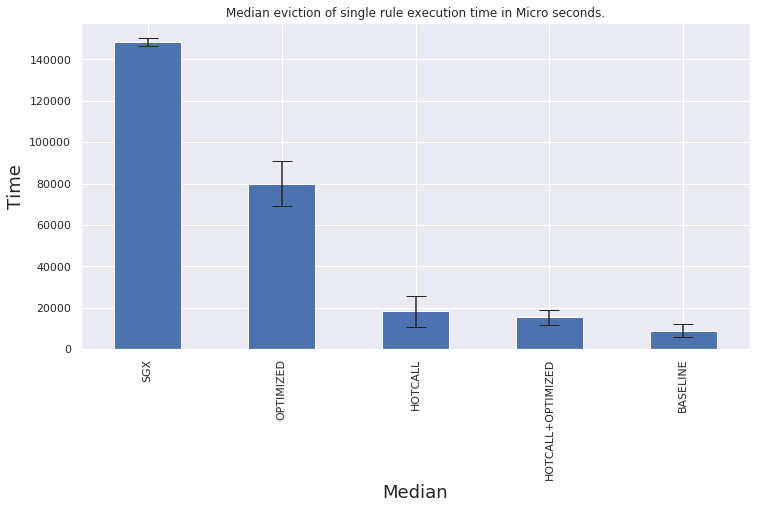

In [159]:
ax = evict_rule_single_df \
    .median() \
    .sort_values(ascending=False) \
    .plot(kind='bar', 
          title="Median eviction of single rule execution time in Micro seconds.", 
          capsize=10, yerr=evict_rule_single_df.std().tolist())
ax.set_xlabel('Median', fontsize=18)
ax.set_ylabel('Time', fontsize=18)

Text(0, 0.5, 'Time')

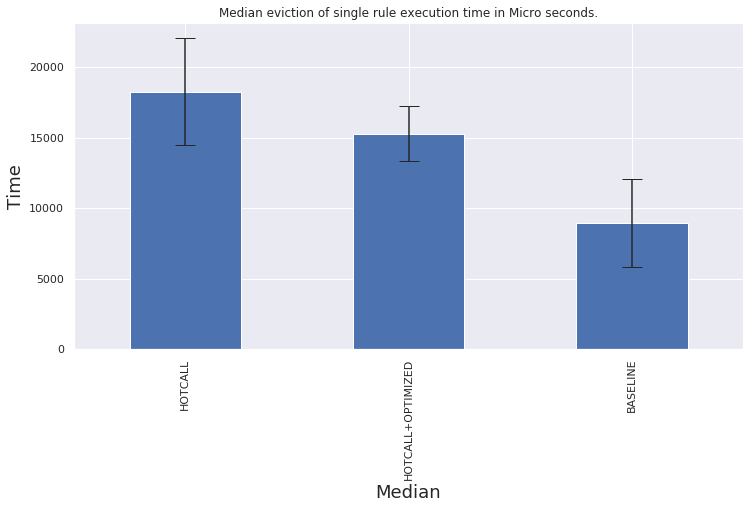

In [160]:
cols = ['HOTCALL', 'BASELINE', 'HOTCALL+OPTIMIZED']
ax = evict_rule_single_df[cols] \
    .median() \
    .sort_values(ascending=False) \
    .plot(kind='bar', 
          title="Median eviction of single rule execution time in Micro seconds.", 
          capsize=10, yerr=evict_rule_single_df[cols].std().tolist())
ax.set_xlabel('Median', fontsize=18)
ax.set_ylabel('Time', fontsize=18)

# 2 Stats requests <a class="anchor" id="2"></a>

## 2.1 Dump flows <a class="anchor" id="2.1"></a>

In [161]:
dump_flows_df = pd.read_csv(DATA_PATH + "/dump_flows.csv");

In [162]:
dump_flows_df = dump_flows_df\
    .mask(dump_flows_df > dump_flows_df.quantile(0.95), axis=0)

In [163]:
dump_flows_df.describe()

,BASELINE,SGX,OPTIMIZED,HOTCALL,HOTCALL+OPTIMIZED
count,4751.000000,4.751000e+03,4751.000000,4751.000000,4751.00000
mean,85421.756893,2.370134e+06,129802.902336,246595.734372,115350.71185
std,16337.474322,1.853921e+05,18122.941070,45329.851780,28536.65638
min,64990.000000,2.121279e+06,100153.000000,194954.000000,79915.00000
25%,72657.500000,2.222913e+06,116333.000000,211584.000000,91601.00000
50%,77518.000000,2.317164e+06,123420.000000,236765.000000,108284.00000
75%,97732.500000,2.477724e+06,140177.500000,263505.000000,129338.00000
max,127343.000000,2.914478e+06,182171.000000,443798.000000,192245.00000


In [164]:
dump_flows_df.median()

BASELINE               77518.0
SGX                  2317164.0
OPTIMIZED             123420.0
HOTCALL               236765.0
HOTCALL+OPTIMIZED     108284.0
dtype: float64

Text(0, 0.5, 'Time')

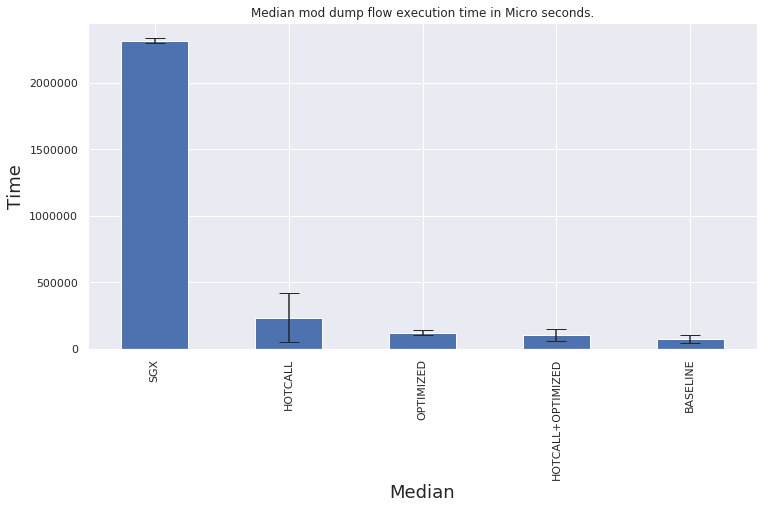

In [165]:
ax = dump_flows_df \
    .median() \
    .sort_values(ascending=False) \
    .plot(kind='bar', 
          title="Median mod dump flow execution time in Micro seconds.", 
          capsize=10, yerr=dump_flows_df.std().tolist())
ax.set_xlabel('Median', fontsize=18)
ax.set_ylabel('Time', fontsize=18)

Text(0, 0.5, 'Time')

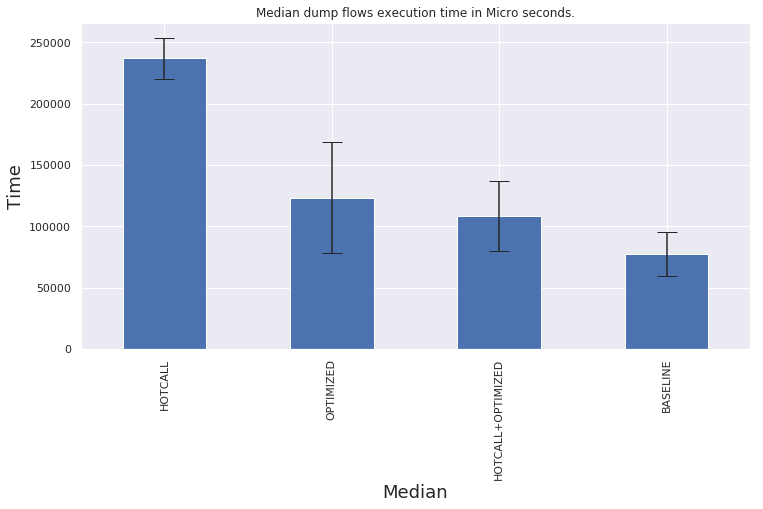

In [166]:
cols = ['BASELINE', 'HOTCALL', 'HOTCALL+OPTIMIZED', 'OPTIMIZED']
ax = dump_flows_df[cols] \
    .median() \
    .sort_values(ascending=False) \
    .plot(kind='bar', 
          title="Median dump flows execution time in Micro seconds.", 
          capsize=10, yerr=dump_flows_df[cols].std().tolist())
ax.set_xlabel('Median', fontsize=18)
ax.set_ylabel('Time', fontsize=18)

Dump flows collect all flows in a flow table from the enclave. The number of ecalls neccesary to carry out this operation grew linerally with the number of flows in the flow table in the baseline application. This was an extremly inefficient solution. The optimized solution uses in the best case scenario a single ecall to fetch all the flow and this is the reason for the extreme speed up.

# 3 Upcall  <a class="anchor" id="3"></a>

## 3.1 force-controller
Every packet is forced to take the slow path and is redirected to controller.

In [8]:
udp_latency_force_controller_df = pd.read_csv(DATA_PATH + "/udp_latency_force_controller.csv");

In [9]:
udp_latency_force_controller_df = udp_latency_force_controller_df\
    .mask(udp_latency_force_controller_df > udp_latency_force_controller_df.quantile(0.95), axis=0)

In [10]:
udp_latency_force_controller_df.median()

BASELINE    0.001849
SGX         0.002283
HOTCALL     0.002129
dtype: float64

Text(0, 0.5, 'Time')

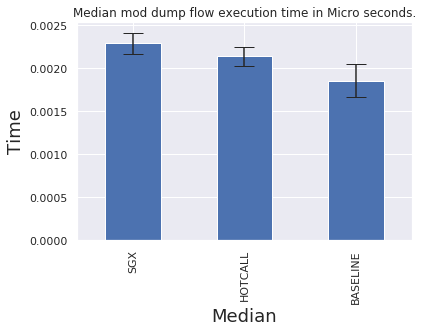

In [11]:
ax = udp_latency_force_controller_df \
    .median() \
    .sort_values(ascending=False) \
    .plot(kind='bar', 
          title="Median mod dump flow execution time in Micro seconds.", 
          capsize=10, yerr=udp_latency_force_controller_df.std().tolist())
ax.set_xlabel('Median', fontsize=18)
ax.set_ylabel('Time', fontsize=18)